In [1]:
import numpy as np
from time import time
from copy import deepcopy
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.ticker import MaxNLocator
%matplotlib inline

In [2]:
class Chessboard:
    def __init__(self,n=4,board_state=None): # inicjalizacja
        self.size = n # do w
        self.board = np.zeros((self.size),dtype=np.int) if board_state is None else board_state  
            
    def getPositions(self):
        return  self.board[:]      
        
    def getNumberOfAttacks(self):
        numberOfAttacks =0
        numberOfAttacks += self.__diagonalAttacks()
        return numberOfAttacks
    
    def CHECK(self): # test poprawności wektora
        counter       = Counter(self.board)
        for value in counter.values():
            if value >1:
                raise Exception('MULTIPLE',' VALUES')
    
    def __diagonalAttacks(self): # mozliwe do poprawy !!!
        diagonalAttacks = 0
        columns = np.arange(0,self.size+1)
        for i,h1 in zip(columns[:-1],self.board[:-1]):
            for j,h2 in zip(columns[i+1:], self.board[i+1:]):
                if i != j and np.abs(i-j) ==np.abs(h1-h2):
                    diagonalAttacks += 1
        return diagonalAttacks
        
    def cutOutVector(self,begin,end ):
        return deepcopy(self.board[begin:end]) # włączamy indeks końca
    
    def injectVector(self,particle,begin,end):
        cutOut = deepcopy(self.board[begin:end])
        self.board[begin:end] = particle 
            
    def getValueOfIndex(self,index):
        return self.board[index]
    
    def setValueOfIndex(self,value,index):
        self.board[index] = value
    
    def getIndexOfValue(self,value,start,stop):
        board = list(self.board)
        return board.index(value,start,stop)
        
    def mutateAtIndexes(self,firstIndex,secondIndex):
        self.board[firstIndex], self.board[secondIndex] = self.board[secondIndex],self.board[firstIndex]
        self.CHECK()
        

In [3]:
def printQueensPositions(chessboard: Chessboard):
    """
    wyświetl pozycje hetmanów na szachownicy w czytelny dla człowieka sposób
    """
    board = chessboard.getPositions()
    width = np.size(board) 
    print("{0}".format(board[:]+1)) # +1 dla czytelności 

In [4]:
def printPopulation(population ):
    print("-------------------------------------------------------------------")
    print("  Subject | Subject code ")
    print("__________________")
    for i, chessboard in enumerate(population):
        print("  {}.  |".format(i+1),end=" ")
        printQueensPositions(chessboard)
    print("__________________")

In [5]:
def printStats(result: Chessboard, BestScore,totalTime):
    """
    wyświetl statystyki jednej iteracji eksperymentu
    """
    
    printQueensPositions(result)
    print("Best Score: {0}".format(BestScore))
    print("Time spent: {0}".format(totalTime), end='\n\n')

In [6]:
def drawPlots(size, bestData, avgScore):
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,10))
    
                         
    
    ax1.plot(range(len(bestData)), bestData, marker='o')
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.set_title("{} Queens | Best Individual".format(size))
    ax1.set_xlabel("n Generation")
    ax1.set_ylabel("Best Score")

    
    ax2.plot(range(len(avgScore)),avgScore, marker='o')
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_title("{} Queens | Mean Scores".format(size))
    ax2.set_xlabel("n Generation")
    ax2.set_ylabel("Mean Scores")
    
    plt.show()

In [7]:
class PMX:

    def __init__(self,X,Y,n):
        self.X = X
        self.Y = Y
        self.n =n
    
    def cross(self,begin,end):
        firstParticle, secondParticle  = self.__cutOutParticles( begin, end)
        
        self.X.injectVector(secondParticle,begin,end)
        self.Y.injectVector(firstParticle,begin,end)
        
        firstMap, secondMap = self.__createMappingDicts(begin,end)
        
        self.__correctOffspring(self.X,firstMap,begin, end )
        self.__correctOffspring(self.Y,secondMap,begin, end )
        return self.X, self.Y
        
    
    def __cutOutParticles(self, begin, end):
        firstParticle  = self.X.cutOutVector(begin, end)
        secondParticle = self.Y.cutOutVector(begin, end)
        return firstParticle, secondParticle
    
    def __createMappingDicts(self,begin,end):
        firstMap = {}
        secondMap ={}
        for i in range(begin,end):
            firstValue = self.X.getValueOfIndex(i)
            secondValue = self.Y.getValueOfIndex(i)
            if firstValue != secondValue:
                firstMap[firstValue] = secondValue
                secondMap[secondValue] = firstValue
            
        firstMap = self.__correctMapping(firstMap)
        secondMap = self.__correctMapping(secondMap)
        return firstMap,secondMap
    
    def __correctMapping(self,mapping):
        MainStack = []
        newMap ={}
        for key,value in mapping.items():
            stack =[]
            if [key,value] not in MainStack:
                stack.append([key,value])
                stack = self.__searchForKeyFromValue(mapping,stack)
                MainStack +=stack
                newKey,newValue = self.__getNewKeyAndValue(stack)
                newMap[newKey]=newValue
        return newMap
    
    def __searchForKeyFromValue(self,mapping,stack):
        while True:
            oldKey,oldValue = self.__popStack(stack)
            keys = list(mapping.keys())
            try:
                index = keys.index(oldValue)
                newKey =keys[index]
                newValue =mapping[newKey]
                if [newKey,newValue] not in stack:
                    stack.append([newKey,newValue])
                else:
                    return stack
            except ValueError:
                return stack
        
    
    def __popStack(self,stack):
        return stack[-1][0],stack[-1][1]
    
    def __getNewKeyAndValue(self,stack):
        return stack[0][0], stack[-1][-1]
    
    def __correctOffspring(self,chessboard,mappingList,begin, end): # TODO można poprawić
        for key, value in mappingList.items():
            try:
                index = chessboard.getIndexOfValue(key,0,begin)
                chessboard.setValueOfIndex(value,index)
            except ValueError:
                try:
                    index = chessboard.getIndexOfValue(key,end,self.n)
                    chessboard.setValueOfIndex(value,index)
                except ValueError:
                    pass

In [8]:
class EvolutionAlgorithm:
    
    def __init__(self, chessboardSize=4, populationSize=5 ,crossDiscriminator=0.7,
                 mutationDiscriminator=0.2,maxGeneration=1000, FFMAX=0):
        
        self.__generation = 0
        self.__FFMAX = FFMAX
        self.__chessboardSize = chessboardSize
        self.__populationSize = populationSize
        self.__crossDiscriminator = crossDiscriminator
        self.__mutationDiscriminator = mutationDiscriminator
        self.__maxGeneration = maxGeneration
        self.__generateInitialPopulation()
        printPopulation(self.__initialPopulation)
        self.bestData =[]
        self.meanScore = []
        
    def __generateInitialPopulation(self):
        self.__initialPopulation = []
        for i in range(populationSize):
            rng = np.random.default_rng()
            boardState = rng.permutation(self.__chessboardSize )
            chessboard = Chessboard(n=self.__chessboardSize, board_state=boardState)
            self.__initialPopulation.append(chessboard)
            
    def doTheEvolution(self): #main function

        currentPopulation = self.__initialPopulation
        evaluateScroes = self.__evaluate(currentPopulation,self.__populationSize )
        BestIndex = self.__getIndexOfBestPopulation(evaluateScroes)
        self.__appendMeanScores(evaluateScroes)
        self.__appendBestData(evaluateScroes[BestIndex])
        
        while(self.__isGenerationUnderLimit() and self.__isSolutionNotFound(evaluateScroes,BestIndex)):
            self.__newPopulation = self.__selection(currentPopulation)
            self.__crossover()
            self.__mutation()
            evaluateScroes = self.__evaluate(self.__newPopulation,self.__populationSize )
            BestIndex = self.__getIndexOfBestPopulation(evaluateScroes)
            currentPopulation = self.__newPopulation
            self.__increseGenerationCounter()
            
            self.__appendMeanScores(evaluateScroes)
            self.__appendBestData(evaluateScroes[BestIndex])
            
        BestScore = evaluateScroes[BestIndex]
        return currentPopulation[BestIndex], BestScore ,self.bestData, self.meanScore
        
    
    def __evaluate(self,currentPopulation, size): # zwróć liczbę ataków między hetmanami na szachownicy 
        evaluateScroes = np.zeros(size,dtype=np.int8)
        currentPopulation = self.__checkIfTypeOfList(currentPopulation)        
        for i, chessboard in zip(range(size),currentPopulation):
            evaluateScroes[i] = chessboard.getNumberOfAttacks()
        return evaluateScroes
    
    def __checkIfTypeOfList(self,subject):
        if type(subject) != list:
            subject = [subject]
        return subject
    
    def __getIndexOfBestPopulation(self, evaluateScroes):
        return np.argmin(evaluateScroes)
    
    def __isGenerationUnderLimit(self):
        return self.__generation < self.__maxGeneration
    
    def __isSolutionNotFound(self,evaluateScroes,BestIndex):
        BestScore = evaluateScroes[BestIndex]
        return BestScore > self.__FFMAX
    
    def __selection(self,currentPopulation): # selekcja turniejowa
        newPopulation = []
        for i in range(populationSize):
            firstOpponentIndex,secondOpponentIndex = self.__drawIndexes(self.__populationSize)
            if firstOpponentIndex != secondOpponentIndex:
                firstOpponent = currentPopulation[firstOpponentIndex]
                secondOpponent = currentPopulation[secondOpponentIndex]
                winner = firstOpponent if self.__isFirstTheWinner(firstOpponent,secondOpponent ) else secondOpponent
                newPopulation.append(deepcopy(winner))
            else:
                withoutRival = currentPopulation[i]
                newPopulation.append(deepcopy(withoutRival))
        return newPopulation
            
    def __drawIndexes(self, size):
        first  = np.random.randint(low=0, high=size-1)
        second = np.random.randint(low=0, high=size-1)
        return first,second
    
    def __isFirstTheWinner(self,firstOpponent,secondOpponent ):
        firstScore  = self.__evaluate(firstOpponent,1)
        secondScore = self.__evaluate(secondOpponent,1)
        return firstScore <= secondScore
    
    def __crossover(self):
        for index in range(0,self.__populationSize-2,2):
            randomState = self.__getRandomValue()
            if randomState <= self.__crossDiscriminator:
                self.__cross(index, index +1)
            
    def __getRandomValue(self):
        return np.random.rand(1)[0]
    
    def __cross(self, firstIndex, secondIndex):
        firstChessboard                = self.__newPopulation[firstIndex]
        secondChessboard               = self.__newPopulation[secondIndex]
        begin, end                     = self.__setBoundaries()
        end +=1 #inclusive end of vector 
        
        pmx = PMX(firstChessboard,secondChessboard, self.__chessboardSize)
        firstChessboard,secondChessboard =pmx.cross(begin,end)
        firstChessboard.CHECK()
        secondChessboard.CHECK()
        self.__newPopulation[firstIndex] = firstChessboard
        self.__newPopulation[secondIndex] = secondChessboard
        
    def __setBoundaries(self):
        begin,end = self.__drawIndexes(self.__chessboardSize)
        while begin == end:
            begin,end = self.__drawIndexes(self.__chessboardSize)
        if end < begin:
            begin,end = end,begin
        return begin,end
     
    def __mutation(self):
        for index in range(self.__populationSize):           
            randomState = self.__getRandomValue()
            if randomState <= self.__mutationDiscriminator:
                self.__mutate(index)
                
    def __mutate(self,index):
        chessboard             = self.__newPopulation[index]
        firstIndex,secondIndex = self.__drawIndexes(self.__chessboardSize)
        while firstIndex == secondIndex:
            firstIndex,secondIndex = self.__drawIndexes(self.__chessboardSize)
        chessboard.mutateAtIndexes(firstIndex,secondIndex)
    
    def __increseGenerationCounter(self):
        self.__generation += 1
        
    def __appendBestData(self,best):
        self.bestData.append(best)
        
    def __appendMeanScores(self,evaluateScores):
        score = np.mean(evaluateScores)
        self.meanScore.append(score)

................................................................................
Number of Queens: 4
Crossing Discriminator: 0.75
Mutation Discriminator: 0.3
-------------------------------------------------------------------
  Subject | Subject code 
__________________
  1.  | [4 1 3 2]
  2.  | [3 2 4 1]
  3.  | [3 4 2 1]
  4.  | [1 4 3 2]
  5.  | [1 3 2 4]
  6.  | [4 3 1 2]
  7.  | [3 2 1 4]
  8.  | [1 2 3 4]
  9.  | [2 1 3 4]
  10.  | [4 3 2 1]
  11.  | [1 2 4 3]
  12.  | [3 1 4 2]
  13.  | [1 2 3 4]
  14.  | [1 3 2 4]
  15.  | [1 4 2 3]
  16.  | [3 1 2 4]
  17.  | [2 1 4 3]
  18.  | [1 3 2 4]
  19.  | [2 3 1 4]
  20.  | [4 2 3 1]
__________________
[3 1 4 2]
Best Score: 0
Time spent: 0.01683330535888672



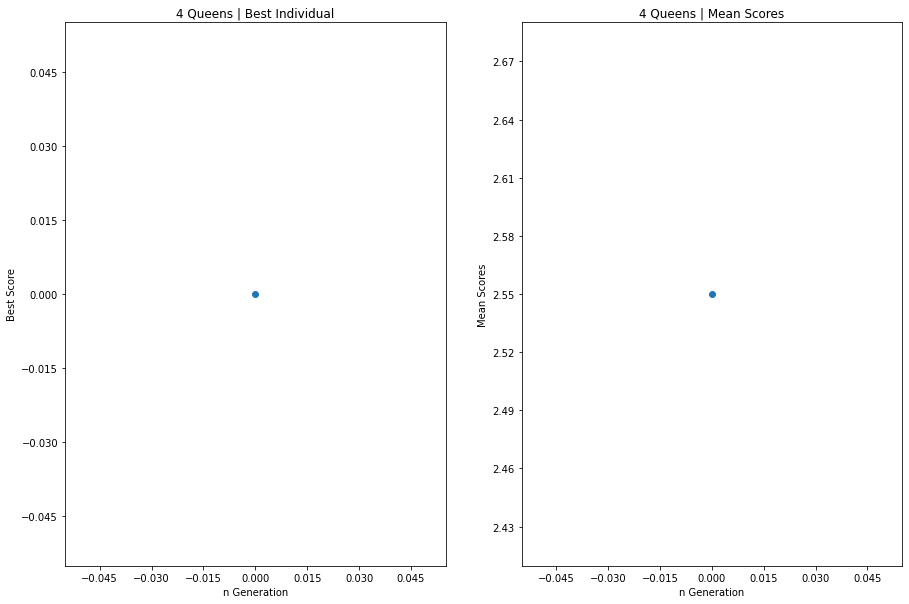

................................................................................
Number of Queens: 5
Crossing Discriminator: 0.75
Mutation Discriminator: 0.3
-------------------------------------------------------------------
  Subject | Subject code 
__________________
  1.  | [2 5 4 1 3]
  2.  | [1 2 3 4 5]
  3.  | [1 4 2 3 5]
  4.  | [4 2 5 1 3]
  5.  | [5 3 1 4 2]
  6.  | [1 4 3 2 5]
  7.  | [3 1 5 4 2]
  8.  | [4 3 5 1 2]
  9.  | [2 1 5 4 3]
  10.  | [1 5 4 2 3]
  11.  | [2 3 5 1 4]
  12.  | [1 2 4 5 3]
  13.  | [2 1 3 4 5]
  14.  | [1 3 5 2 4]
  15.  | [2 4 3 1 5]
  16.  | [3 1 4 2 5]
  17.  | [3 5 1 2 4]
  18.  | [2 1 3 4 5]
  19.  | [1 3 4 5 2]
  20.  | [5 4 1 3 2]
__________________
[5 3 1 4 2]
Best Score: 0
Time spent: 0.0



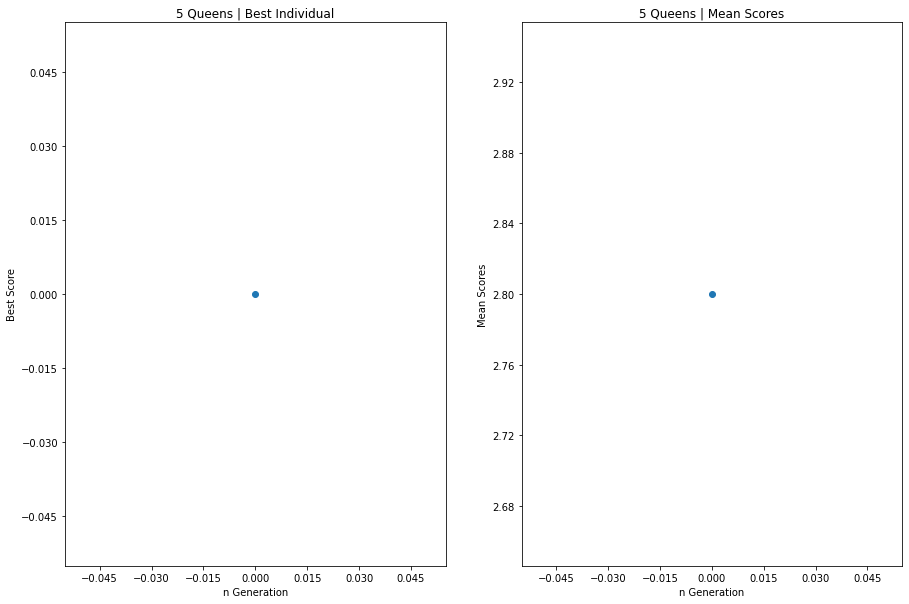

................................................................................
Number of Queens: 6
Crossing Discriminator: 0.75
Mutation Discriminator: 0.3
-------------------------------------------------------------------
  Subject | Subject code 
__________________
  1.  | [1 5 4 6 3 2]
  2.  | [6 1 5 3 4 2]
  3.  | [4 6 2 1 5 3]
  4.  | [6 3 1 5 2 4]
  5.  | [5 6 3 2 4 1]
  6.  | [1 6 4 2 3 5]
  7.  | [6 3 1 5 2 4]
  8.  | [3 2 4 6 1 5]
  9.  | [5 4 3 2 1 6]
  10.  | [4 2 1 3 6 5]
  11.  | [4 3 2 1 6 5]
  12.  | [5 4 3 2 6 1]
  13.  | [2 3 6 4 5 1]
  14.  | [5 4 1 3 6 2]
  15.  | [4 2 3 6 1 5]
  16.  | [1 6 3 5 4 2]
  17.  | [3 1 4 6 2 5]
  18.  | [1 2 4 3 6 5]
  19.  | [1 3 6 5 2 4]
  20.  | [5 4 2 1 6 3]
__________________
[2 4 6 1 3 5]
Best Score: 0
Time spent: 0.1536266803741455



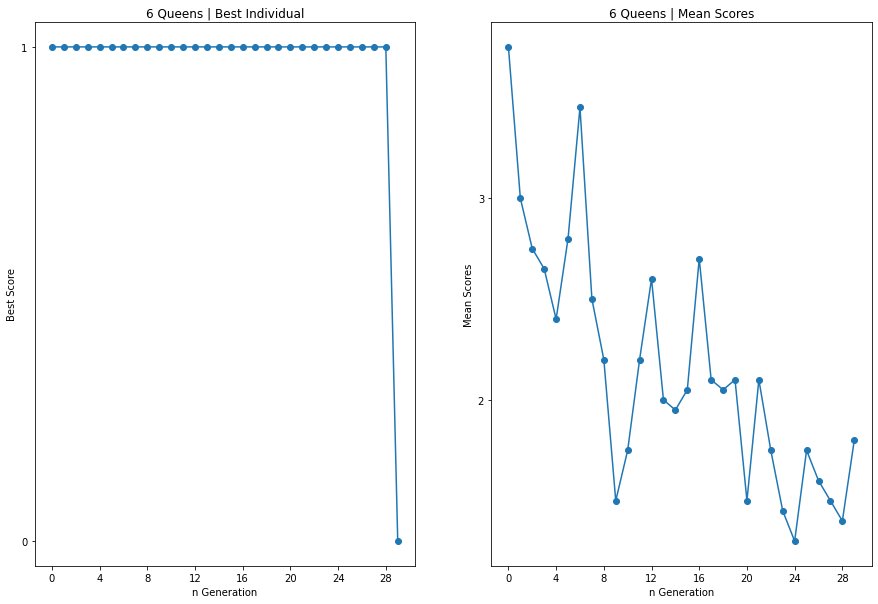

................................................................................
Number of Queens: 7
Crossing Discriminator: 0.75
Mutation Discriminator: 0.3
-------------------------------------------------------------------
  Subject | Subject code 
__________________
  1.  | [2 6 3 7 4 5 1]
  2.  | [2 4 6 3 5 7 1]
  3.  | [3 2 5 7 1 4 6]
  4.  | [3 1 5 6 7 4 2]
  5.  | [1 6 4 2 5 7 3]
  6.  | [6 7 4 1 3 5 2]
  7.  | [6 7 3 2 1 4 5]
  8.  | [3 1 2 6 4 5 7]
  9.  | [4 7 3 1 6 2 5]
  10.  | [3 1 2 6 4 7 5]
  11.  | [5 1 4 2 7 6 3]
  12.  | [1 2 5 4 7 3 6]
  13.  | [3 5 6 1 7 4 2]
  14.  | [4 2 6 1 5 3 7]
  15.  | [5 3 6 1 2 4 7]
  16.  | [7 3 2 6 4 5 1]
  17.  | [7 1 4 3 6 2 5]
  18.  | [1 3 7 5 6 2 4]
  19.  | [5 7 2 4 1 6 3]
  20.  | [7 6 3 1 5 2 4]
__________________
[6 2 5 1 4 7 3]
Best Score: 0
Time spent: 0.006525516510009766



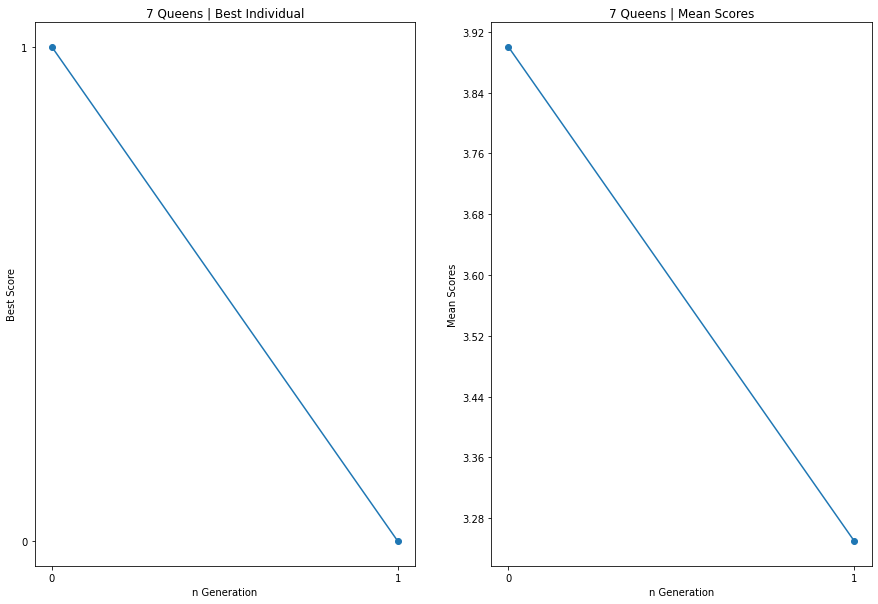

................................................................................
Number of Queens: 8
Crossing Discriminator: 0.75
Mutation Discriminator: 0.3
-------------------------------------------------------------------
  Subject | Subject code 
__________________
  1.  | [7 2 6 5 1 4 3 8]
  2.  | [2 6 8 3 7 1 5 4]
  3.  | [4 7 1 8 5 3 6 2]
  4.  | [4 7 8 5 2 1 3 6]
  5.  | [4 3 1 5 7 6 2 8]
  6.  | [2 5 7 1 6 8 3 4]
  7.  | [4 2 5 1 7 8 3 6]
  8.  | [2 1 6 4 5 3 7 8]
  9.  | [8 2 7 5 3 1 4 6]
  10.  | [6 3 7 8 5 4 2 1]
  11.  | [3 1 4 8 5 6 7 2]
  12.  | [5 7 8 2 6 1 3 4]
  13.  | [1 7 4 3 6 8 2 5]
  14.  | [1 4 3 6 5 8 2 7]
  15.  | [6 4 7 1 2 8 5 3]
  16.  | [6 4 1 2 7 5 3 8]
  17.  | [4 8 7 5 6 1 3 2]
  18.  | [4 2 3 1 7 6 5 8]
  19.  | [8 6 7 2 5 1 3 4]
  20.  | [6 5 3 7 1 4 2 8]
__________________
[2 5 7 1 3 8 6 4]
Best Score: 0
Time spent: 0.1784071922302246



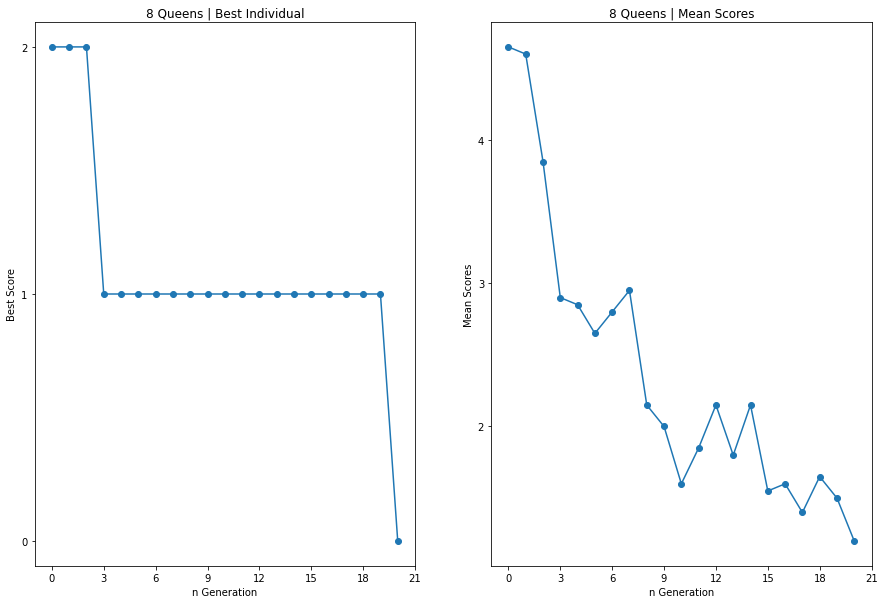

................................................................................
Number of Queens: 9
Crossing Discriminator: 0.75
Mutation Discriminator: 0.3
-------------------------------------------------------------------
  Subject | Subject code 
__________________
  1.  | [1 7 4 6 8 9 2 5 3]
  2.  | [8 5 2 7 1 6 4 3 9]
  3.  | [1 7 3 8 5 6 4 9 2]
  4.  | [7 8 9 5 6 1 3 2 4]
  5.  | [1 8 9 4 7 6 3 2 5]
  6.  | [4 9 8 7 3 6 5 2 1]
  7.  | [3 5 2 6 7 8 1 4 9]
  8.  | [7 5 8 6 4 3 2 1 9]
  9.  | [1 6 5 3 8 4 7 2 9]
  10.  | [5 7 9 1 4 2 6 8 3]
  11.  | [8 5 3 2 1 7 6 9 4]
  12.  | [5 7 4 6 8 2 3 1 9]
  13.  | [6 7 4 1 5 2 8 3 9]
  14.  | [4 3 2 1 9 6 5 7 8]
  15.  | [8 1 7 6 4 2 5 3 9]
  16.  | [1 4 5 7 3 6 8 2 9]
  17.  | [5 8 2 3 7 1 9 6 4]
  18.  | [1 2 5 7 4 8 3 6 9]
  19.  | [1 9 5 4 3 6 2 7 8]
  20.  | [6 2 8 3 7 1 9 5 4]
__________________
[2 9 5 3 8 4 7 1 6]
Best Score: 0
Time spent: 0.07415080070495605



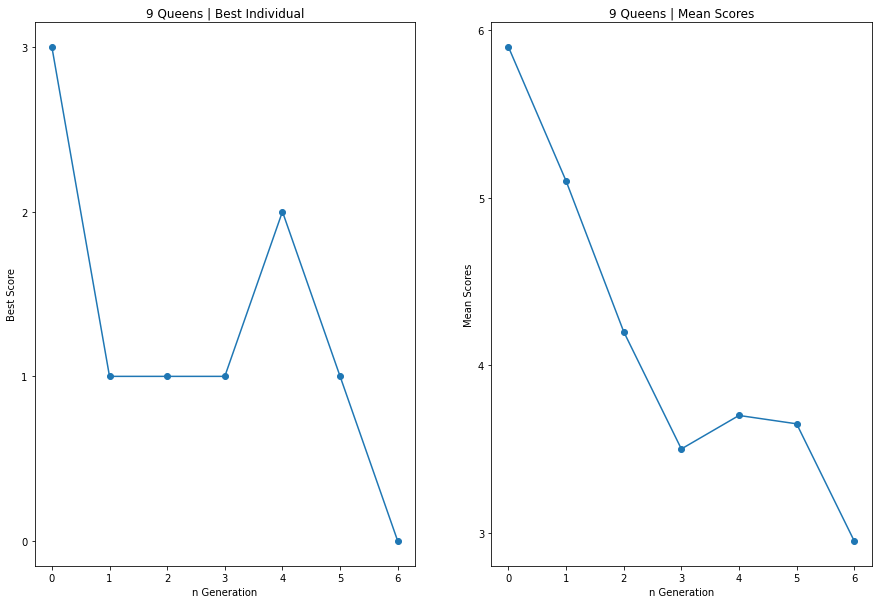

................................................................................
Number of Queens: 10
Crossing Discriminator: 0.75
Mutation Discriminator: 0.3
-------------------------------------------------------------------
  Subject | Subject code 
__________________
  1.  | [ 4  1  8  7  9  2  6 10  3  5]
  2.  | [ 5  8  2  3  9  1  7 10  4  6]
  3.  | [ 3  4 10  5  7  2  1  6  9  8]
  4.  | [ 9 10  6  1  4  7  8  5  2  3]
  5.  | [ 5  3  2  8  9  4  1 10  7  6]
  6.  | [ 1  3 10  5  6  7  9  2  4  8]
  7.  | [ 5  3  8  4  6  2 10  1  7  9]
  8.  | [ 2  5  8  9 10  4  1  6  3  7]
  9.  | [ 3  8  5  2  7  9  1  6 10  4]
  10.  | [ 6  4  5  2  9 10  3  8  1  7]
  11.  | [10  4  7  3  9  1  8  5  6  2]
  12.  | [ 3  2  4  5  6 10  9  8  1  7]
  13.  | [ 8  2  5  3 10  1  9  7  4  6]
  14.  | [ 9  3  5 10  2  8  1  6  4  7]
  15.  | [ 7  6  3  9  2  5  8  4  1 10]
  16.  | [ 6  3  8  1  4  2  7 10  9  5]
  17.  | [ 1  5  6  4  2  7  3  8  9 10]
  18.  | [ 1  5  6  3 10  2  7  4  8  9]

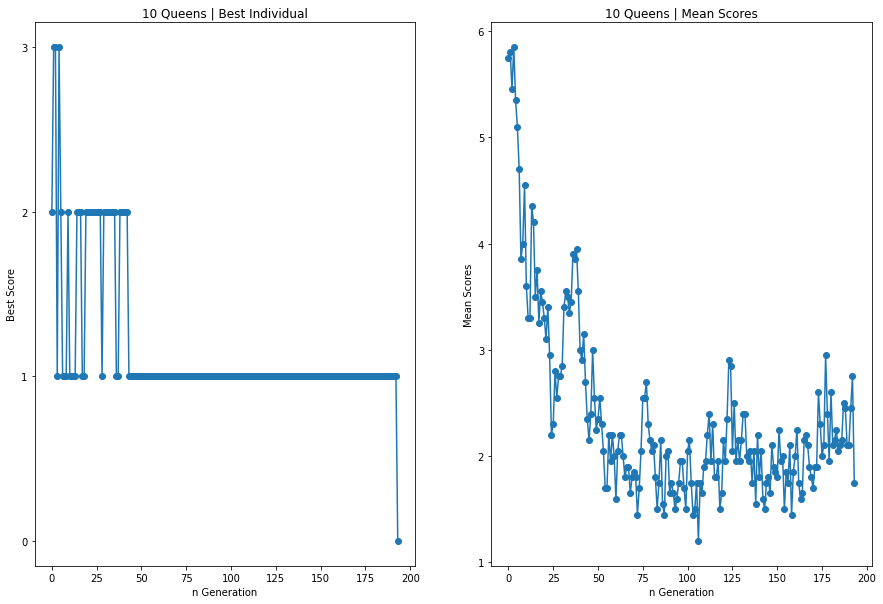

................................................................................
Number of Queens: 11
Crossing Discriminator: 0.75
Mutation Discriminator: 0.3
-------------------------------------------------------------------
  Subject | Subject code 
__________________
  1.  | [ 5  4  1 10 11  9  8  7  3  2  6]
  2.  | [10  9 11  4  8  1  7  5  3  2  6]
  3.  | [ 9  7 11  5 10  6  8  3  4  1  2]
  4.  | [ 2 11  1  5  8  9  6 10  7  3  4]
  5.  | [10  8  7  9  5  3 11  4  2  1  6]
  6.  | [ 1  6  3  8  4 11  7  5  2 10  9]
  7.  | [ 9  5 10  2  8  7 11  1  3  4  6]
  8.  | [10  4  9  8 11  5  7  2  1  3  6]
  9.  | [ 8  6  4 10  3  5 11  7  1  2  9]
  10.  | [11  1  4  8  2  3  9  7 10  6  5]
  11.  | [11  2 10  8  7  3  9  6  1  5  4]
  12.  | [ 3  2  9  6  1  8  7  5 11  4 10]
  13.  | [ 4  7  3  2  6  9  5  1 10  8 11]
  14.  | [10  7  2  1  4  6 11  9  3  8  5]
  15.  | [ 5 10  8  4  9  3  2  6  1  7 11]
  16.  | [ 8  3 11  9  1  7 10  6  5  4  2]
  17.  | [ 4  9  6  3  5 10  7  8

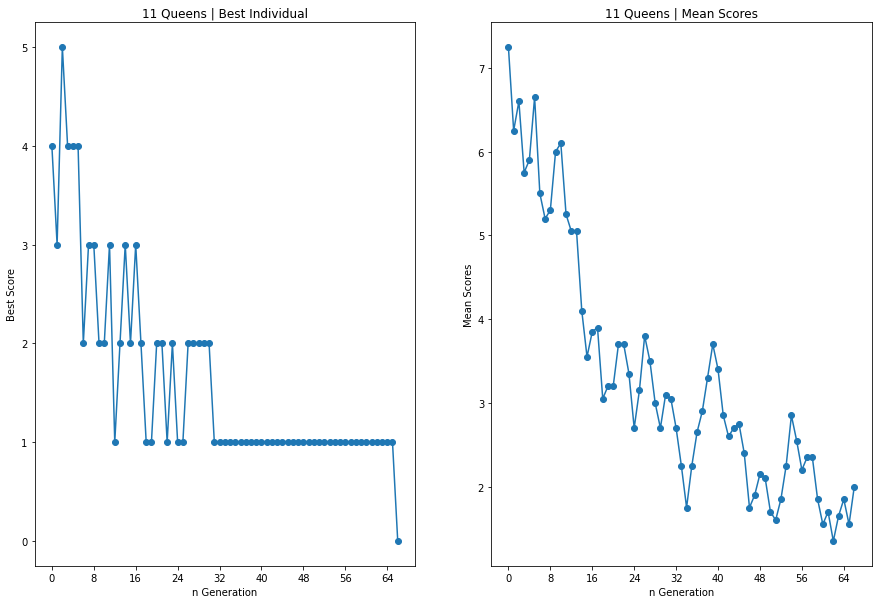

................................................................................
Number of Queens: 12
Crossing Discriminator: 0.75
Mutation Discriminator: 0.3
-------------------------------------------------------------------
  Subject | Subject code 
__________________
  1.  | [ 5 12  4 11  3  6  9  8 10  7  1  2]
  2.  | [ 3  5 10  4  6 12  8  7  1  9 11  2]
  3.  | [ 2  3  1  5 11  6 10  4 12  8  7  9]
  4.  | [11 10  9  4  2  6  3 12  8  7  1  5]
  5.  | [10  4 11  5  1 12  2  6  8  9  3  7]
  6.  | [ 5  7  3 10  9  1 11 12  4  6  8  2]
  7.  | [ 2  4  1 11  5  8  6  3 12 10  9  7]
  8.  | [ 6  5  9  4  7  8 11  3  1 10 12  2]
  9.  | [ 6 10  3 11  7  2  1 12  8  4  5  9]
  10.  | [ 7  8  2  4  1  9 11 10 12  5  6  3]
  11.  | [ 7  8  3  4  5 11 12  6 10  9  1  2]
  12.  | [ 3  6  5  4 12  8  9  1 10  7 11  2]
  13.  | [ 6  3  7 11 12  8  5  1  2  9  4 10]
  14.  | [ 3  9  7 12  8  4 10 11  2  1  5  6]
  15.  | [ 5  8 12  4  6  2  1 10  7  3 11  9]
  16.  | [12  9 10  4  1  5  3  

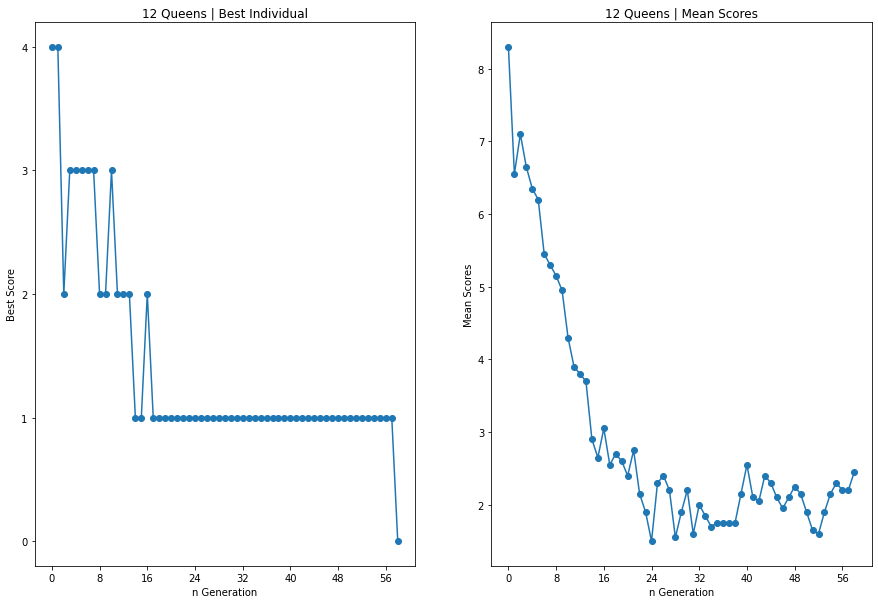

................................................................................
Number of Queens: 13
Crossing Discriminator: 0.75
Mutation Discriminator: 0.3
-------------------------------------------------------------------
  Subject | Subject code 
__________________
  1.  | [ 3  1  6 11 12  8  9 10  2  7 13  5  4]
  2.  | [12  1 11  4  8  9  7 10  6 13  2  3  5]
  3.  | [13  8  1 10 12  3  7  6 11  4  5  2  9]
  4.  | [ 3  5  1  9  4 11 12  2 13  7  6 10  8]
  5.  | [ 1  6  7 13 11  3 10  5  8 12  9  4  2]
  6.  | [ 4 12  9  2  5  6 10 13  3 11  1  7  8]
  7.  | [ 1  3 11 10  9  4  6 13  7 12  8  5  2]
  8.  | [ 4  5 13  7  6 10  2  9  1  3 12  8 11]
  9.  | [ 8  2  6  1 12 13  5 11 10  4  3  7  9]
  10.  | [ 8  4  9  6 10 13  5 12  3 11  7  2  1]
  11.  | [10  9  7  5 11  4  2  8  6 13 12  3  1]
  12.  | [ 6  2  5  9  8 12  1  7  3 10  4 11 13]
  13.  | [ 9  6  4 12  7  3  5  1 13  8  2 10 11]
  14.  | [ 7 10  4  1  6  8 12  2  5 11  9 13  3]
  15.  | [13 10  4  3  1 12  2  8  9 

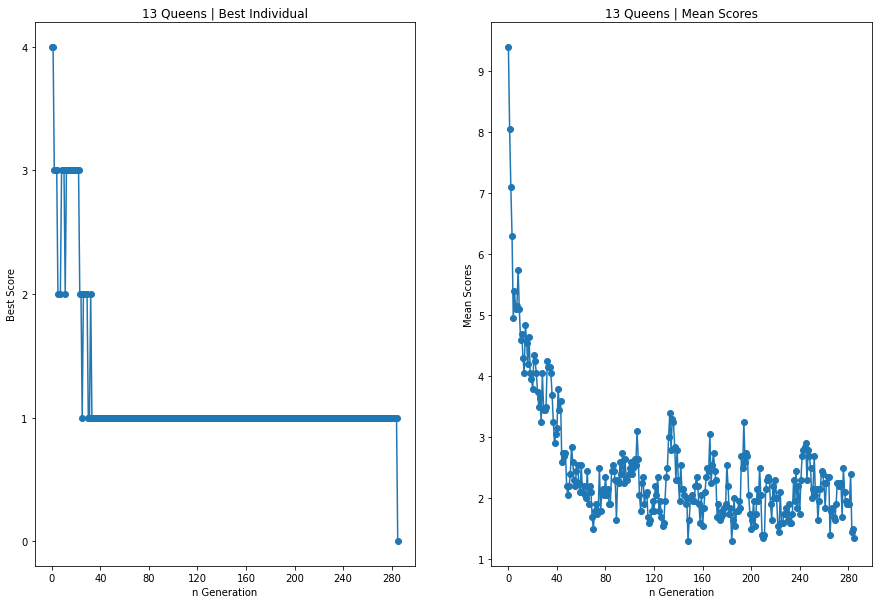

................................................................................
Number of Queens: 14
Crossing Discriminator: 0.75
Mutation Discriminator: 0.3
-------------------------------------------------------------------
  Subject | Subject code 
__________________
  1.  | [ 3 10  1  2 12 11  6  7 14  8 13  5  9  4]
  2.  | [ 4  5  8  9  7  3 14 10 11 12  2  6 13  1]
  3.  | [13 11  7  9  8  6 12 14  4  1 10  5  3  2]
  4.  | [ 3 10  6  2  4 12 11 13  1 14  5  9  8  7]
  5.  | [ 5  6  9 14  8  4  1  3  7  2 12 11 13 10]
  6.  | [11  8  1  5 13  3 14  2 10  7 12  6  9  4]
  7.  | [14  4  8  2  5 12 11  7 13  9  6  1 10  3]
  8.  | [13  3  6 11 12 14  7  1  2  8  4 10  5  9]
  9.  | [ 1  4 11 12  2  8 13  7  5 14  9  3 10  6]
  10.  | [ 2 10 13  3  5 12 14  8  7  1  6 11  4  9]
  11.  | [ 1  4  2  9  3  6 11 12  7  8  5 10 14 13]
  12.  | [ 6  9  5  2 10  4  8  3  7 14  1 13 12 11]
  13.  | [ 6 10  2 14 11  4  8  9  5  1 12  3  7 13]
  14.  | [ 8  5  1 11 14  4  7 10  3  9  2 12  6

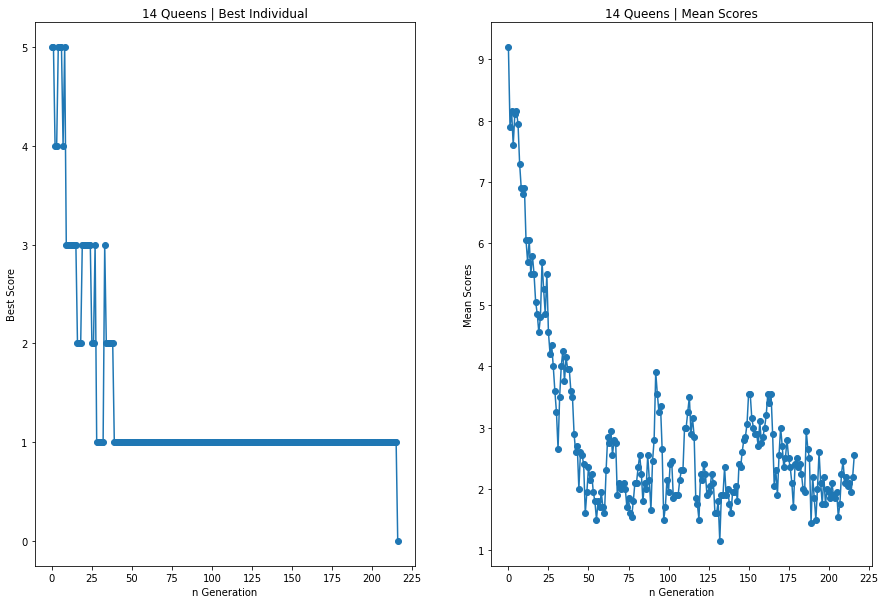

................................................................................
Number of Queens: 15
Crossing Discriminator: 0.75
Mutation Discriminator: 0.3
-------------------------------------------------------------------
  Subject | Subject code 
__________________
  1.  | [ 4 14  6 13 10  7 15 11  8  9  5  2 12  1  3]
  2.  | [ 6 15 11  2  9 10 13  4  7  1 14  5  3  8 12]
  3.  | [13 12  3  6  5  1  7 10 14  8  4 11 15  2  9]
  4.  | [10 13  3 14 15  9  5 12  4 11  1  7  6  8  2]
  5.  | [ 8  4  6  1 13 12  5 10 14 11  7  9  3 15  2]
  6.  | [ 1  3  2  9 12 10 13 15 14  5  8  6  4  7 11]
  7.  | [14  1  8  6 12  7 11  4 10 15  3 13  5  2  9]
  8.  | [15  4  1  8 14 10  2 13  3 12  6  5 11  9  7]
  9.  | [14  9  5 15  2  7  8  4 12  3 11  6 10  1 13]
  10.  | [ 4  5  2 11  7  9 14 15  1 10  8 12  6  3 13]
  11.  | [ 3  7  1 10  8 13 11 14  6  2  5  4 12  9 15]
  12.  | [15 13  7 14  5  3 10  4  6  8  1 12  9  2 11]
  13.  | [11 14  2  3 13  8  7 12  1 10  4  6 15  9  5]
  14.  | 

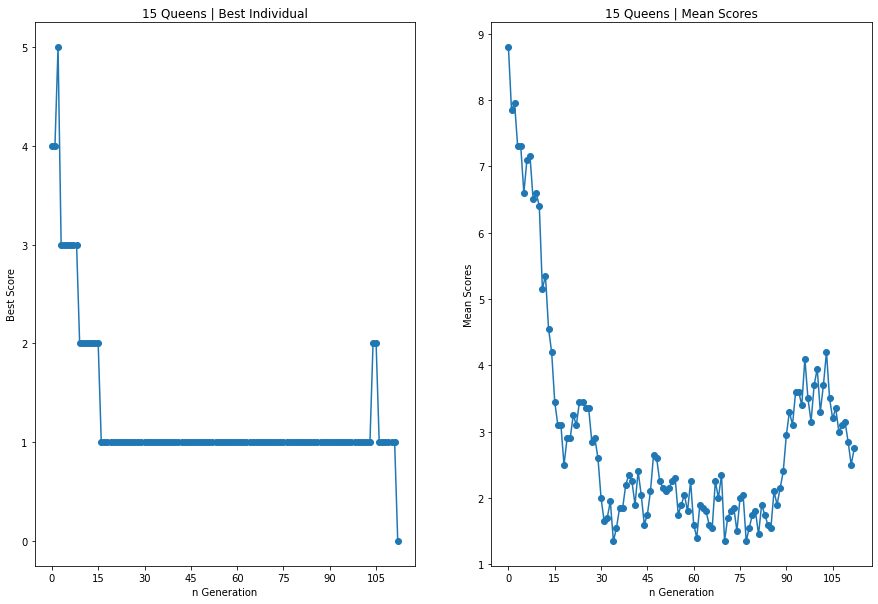

................................................................................
Number of Queens: 16
Crossing Discriminator: 0.75
Mutation Discriminator: 0.3
-------------------------------------------------------------------
  Subject | Subject code 
__________________
  1.  | [ 5 16 10  9  1  8  4  2  6 11 14 13  7 12  3 15]
  2.  | [ 4  6 10  2  9  5 13  3 11 15 14  7  8 16 12  1]
  3.  | [ 8  4 12  5  7 10  2  9 11 16  3 13 14  6  1 15]
  4.  | [ 9  3  4 13 15  2  7 10 16  5 11  1 12  8 14  6]
  5.  | [ 8 12  9 11 14 16  7  3  1 10  5 13 15  4  2  6]
  6.  | [15  9  1  2  5  3 16 11  6  4  8 10 13  7 12 14]
  7.  | [10  1 13  2  7 15  5  9 12 11  8 14  4 16  3  6]
  8.  | [11  3  2  4 13  8  9  5 14 15 10  6 16  7  1 12]
  9.  | [ 1 14 11  3  4 16 10  5 15  6  8 12  2  9 13  7]
  10.  | [ 6  1  3 16  8 10  7  9  5 15 12  4 14 13  2 11]
  11.  | [ 4  2  1 11  9  3 15  8 13  5  7 14 12  6 16 10]
  12.  | [13  2 15  8  5 12  7  9 16 14  4  1  3 10 11  6]
  13.  | [ 5  1  8  6  3  9 1

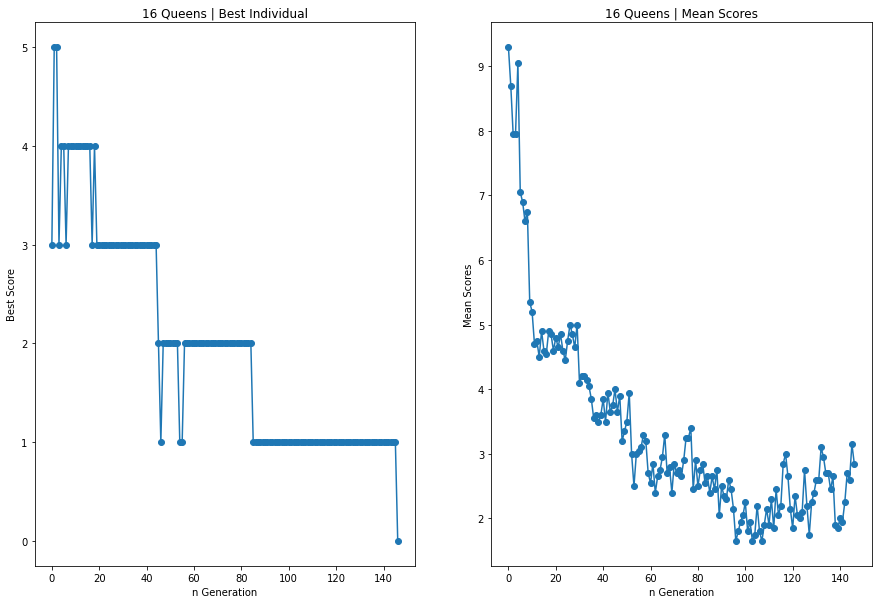

................................................................................
Number of Queens: 17
Crossing Discriminator: 0.75
Mutation Discriminator: 0.3
-------------------------------------------------------------------
  Subject | Subject code 
__________________
  1.  | [ 1 13  8 10  2  3 15  9 17  6  4  7  5 12 14 11 16]
  2.  | [17  7 11  8  6  9 13 12  2 14  3  5 10 16  4 15  1]
  3.  | [ 5 12 15 13 10 11  3  4  7  2  6 16 17 14  9  1  8]
  4.  | [ 2  1  4  8  9  3 15 12 17  7 14 16 13 11  6 10  5]
  5.  | [ 3  1  6 13 16  4  8 15  2 14 17  9  7  5 12 10 11]
  6.  | [ 5 13 16  9  7 10 12 14  3  6  8 15  1 11  4  2 17]
  7.  | [13 14  8 15  6 10  2  4  7 12 16 17 11  1  9  3  5]
  8.  | [15  2  4  8  9  5  1 16 12 17 10  7 11 14  6 13  3]
  9.  | [ 9 16 11 12 17  8 14 13  2  6 15 10  3  5  4  1  7]
  10.  | [10  6  4 11 14  9 13  2 16 15  3  1 17  7  8  5 12]
  11.  | [14  6 11  2  7  1 13 16 15 12  5 17  9 10  4  3  8]
  12.  | [ 5  6 12 10 11  7  9 14  1 13  4  2  3 17 16 

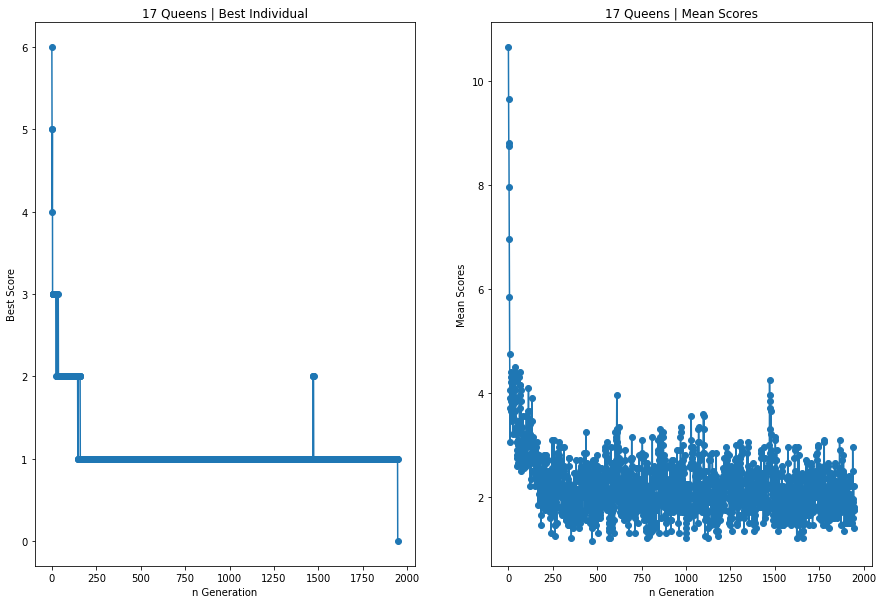

................................................................................
Number of Queens: 18
Crossing Discriminator: 0.75
Mutation Discriminator: 0.3
-------------------------------------------------------------------
  Subject | Subject code 
__________________
  1.  | [17 18  2 14  3 12 13  4 11 15 10  7  1  9  6  8 16  5]
  2.  | [12 11  5  4  6  1 13  7 16 18 17  9  8  2 15  3 14 10]
  3.  | [12  6 11  7 10 13 18  5  3  9 14 16  1 17 15  4  2  8]
  4.  | [16  6  2 10  9  1  8 13  7 14 12 15  4  5  3 17 11 18]
  5.  | [11 13 16 14  7  8  1 17  6  3  2  5 15 12 10  4  9 18]
  6.  | [ 2  3 16  7  1  8 17 14  5 18 10 11 12  4  9  6 13 15]
  7.  | [16  2  7  4 18  8 11 13  3  6 17 14  5 15 12  9  1 10]
  8.  | [12 14  6  1  2  8 15 18  4 13  7 10 16 11  9  5 17  3]
  9.  | [ 8 18 15 17  3 11 14 10  2 16  4  9 12  6 13  7  1  5]
  10.  | [11  5 12 10 18  1  7  8  4 15 14 16 17  6 13  3  2  9]
  11.  | [17 15  3  6  2  5  8  9 11 10  1 12  4  7 16 13 18 14]
  12.  | [ 3 10  1 14 

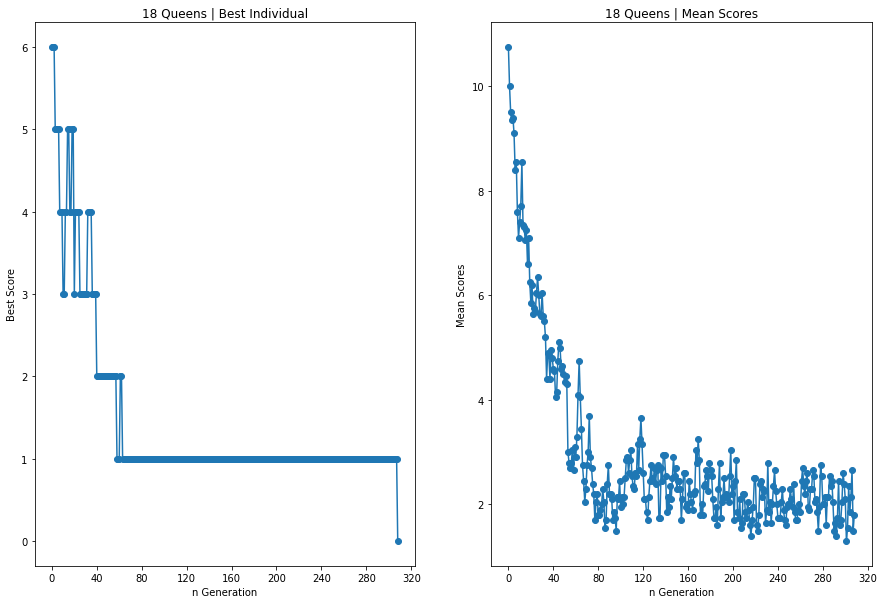

................................................................................
Number of Queens: 19
Crossing Discriminator: 0.75
Mutation Discriminator: 0.3
-------------------------------------------------------------------
  Subject | Subject code 
__________________
  1.  | [19 14  4  6 15 12  3  7 13  9  8 17  1  2 10 11 18  5 16]
  2.  | [ 4 18  6  2 10 13  7 17 15  3  1  8 12 16 14 19  5 11  9]
  3.  | [10 19 18  9  2 14 15 11 16  4  8 13  1  6 17  5  3 12  7]
  4.  | [19 10  9  4 17 12 11 14 18 13  6  8  1  7  2 15  5  3 16]
  5.  | [ 9  3 12 19  8  1  6 18 10 13  5  2 15 11  4 16 17  7 14]
  6.  | [ 6 13 15  7 12 17 16 10  4 18  1 14  2  3 11  9  5 19  8]
  7.  | [ 6  4 14 12 13 19  1 17  9  2  8 10 11  7 18  5 16 15  3]
  8.  | [18  1 14 12  5 15  4  2 17 19 11  3 10  9  7 16 13  8  6]
  9.  | [10  9 19  7  4 18 15  2  3 12 11  5 17  8 16  1 14  6 13]
  10.  | [11 19 18  7 16  8 17 12  9  4  6  3 15  5 13  2 10  1 14]
  11.  | [17  5 19  4 13 15  6 16  9  2  3 14 18  1 12 11

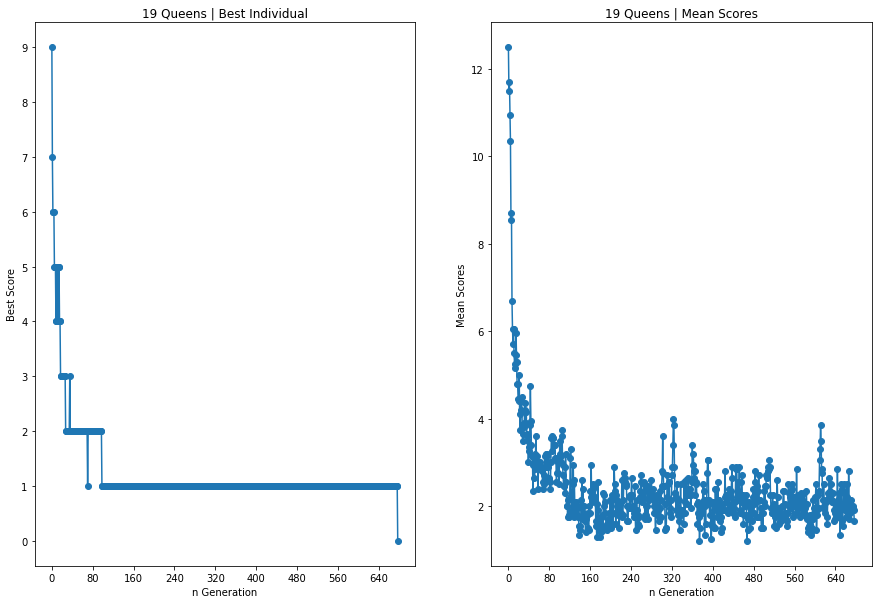

................................................................................
Number of Queens: 20
Crossing Discriminator: 0.75
Mutation Discriminator: 0.3
-------------------------------------------------------------------
  Subject | Subject code 
__________________
  1.  | [11 16  1 10  4  3  9 14 20  5 18 17 15  2 13  7  8 12 19  6]
  2.  | [18  3  2 14 16 15 19  4 11  1  6 10 20 17 12  5  9 13  8  7]
  3.  | [ 8  9 18  3 12 20 17 13  2  7 19  6  4 14 10 15 16 11  5  1]
  4.  | [ 8  4  2 20  6 13 11 15 10 18  5  7 14 17 12  1  3 16 19  9]
  5.  | [13  2 16  9  1 17 14  5 15 11  6 20 12  8  7 19  4  3 18 10]
  6.  | [ 8  6  9 13 17 14 11  3 15 12  5  4  2  1  7 19 18 20 16 10]
  7.  | [ 7  6 18 11 19 20  1 14 16 15  9  5  4 13 12 10  3 17  8  2]
  8.  | [14  6 11 17 16 20  8  5 19  4 12  9 13 15 10  2  3  7 18  1]
  9.  | [ 5  7 19  8  2  9 12  6 15 14 10 17  4  1 13 11 20  3 18 16]
  10.  | [ 4  9  8 12  5 15 20 18  7 13  6 19 17  3  2 10  1 14 11 16]
  11.  | [18  1 13  3  5  9

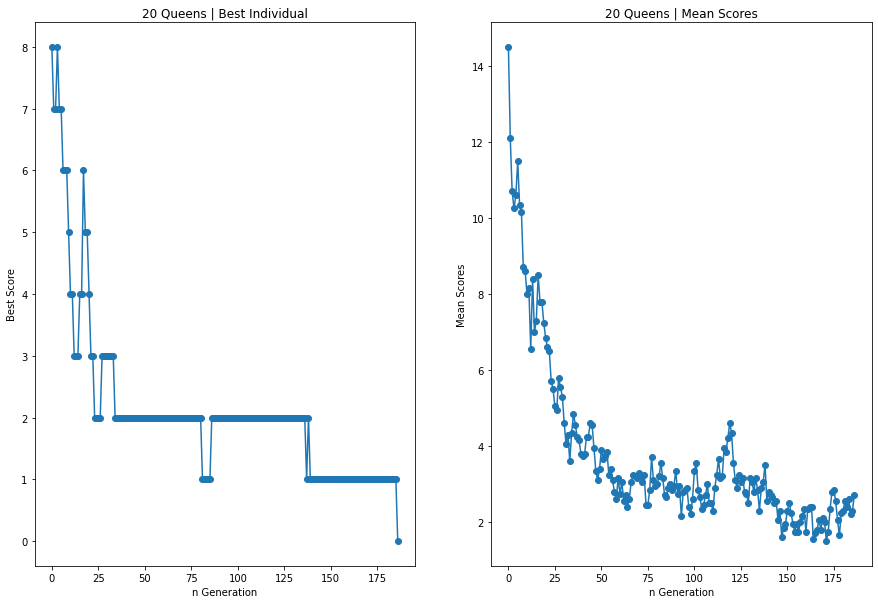

................................................................................
Number of Queens: 21
Crossing Discriminator: 0.75
Mutation Discriminator: 0.3
-------------------------------------------------------------------
  Subject | Subject code 
__________________
  1.  | [10 15  3  7  5 21  8 18  2 19  4 16 20  9 12 14  6 13 11  1 17]
  2.  | [15  3  4 13 19  6 20 18  5  9  8  1 10 11  2  7 14 21 12 17 16]
  3.  | [ 3  7 16  8  4 18 15  6 12 11 17  2 13 20  9  5 21 14  1 19 10]
  4.  | [ 5  2  1 20 16 21 12 19  4  8 15  6  7  3 10  9 17 11 14 18 13]
  5.  | [ 8  7 17 15 20 12 11 19  5  3 21  1 18  6 10  9 13 14  4  2 16]
  6.  | [ 7 16 19 18  2 13 15 17 20 12  9  6 11  1 14  8  3 10  5 21  4]
  7.  | [17  5 15 11 16 21  7  4 13  6 20  9  3  1  8 18 14 19  2 10 12]
  8.  | [14 13 21  6 10  5 15 20  1 11 19  4 17  3  7  2 12 16 18  9  8]
  9.  | [ 8  6  4  5 21 13 18 19 15 10  9  3 17 16 12 11  2 20 14  7  1]
  10.  | [15  6 18 21 20  2  8  7 11 12 19 16  1  3 10 14 17  5  4  9 1

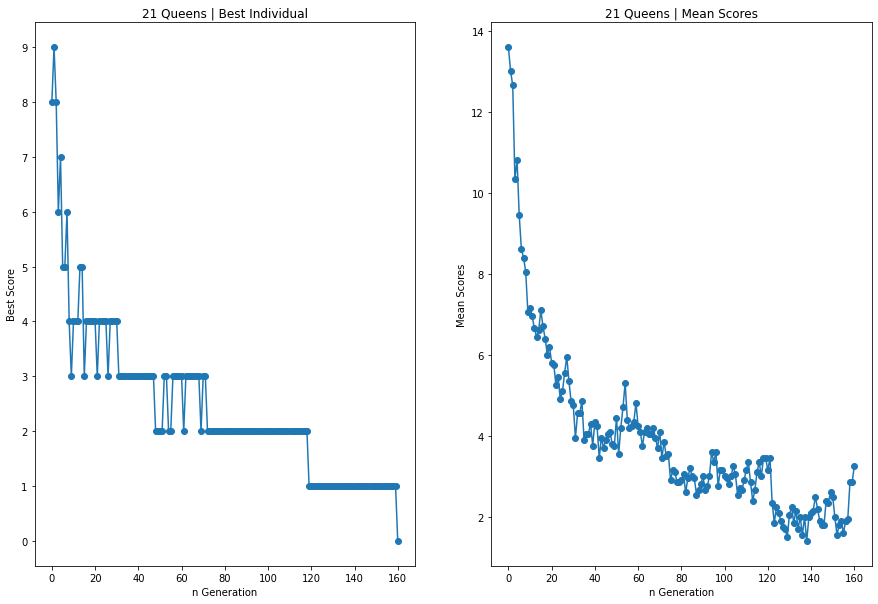

................................................................................
Number of Queens: 22
Crossing Discriminator: 0.75
Mutation Discriminator: 0.3
-------------------------------------------------------------------
  Subject | Subject code 
__________________
  1.  | [ 7 21 16  4  8 22  6  2  9 14 12 11 18  1 13  5 15 10  3 19 20 17]
  2.  | [ 7 21 14 13 22  1  8 20 16 18  6  3 10 15  5  4  9 19  2 17 12 11]
  3.  | [14 20  1  3 13  8 19  2 17  6 21 16 12 22  4 10  5  9 18 15  7 11]
  4.  | [ 6 14  7 19 15  2  9 11 22 17  8  3 12 10  5 16  4 20  1 13 18 21]
  5.  | [14  4 15  1  2  5 22  6  9  7 16 13  3 12 11 18 20 21 19 17 10  8]
  6.  | [ 5 10  3 19 11  6 18  8  1 14 17 15  4 16  2 22 20 13 21  7  9 12]
  7.  | [12  8 13 11 22  3  7  1 17  6 19  4 15  2 10 21  5 14 16 18  9 20]
  8.  | [10 16 12  3  8  9 20  5 13 14  4 19 17  6 22 15 11 21  7 18  1  2]
  9.  | [ 8  5 21 19  2 14  7 20  6 11 16 22  9  3  4 13 12 18  1 15 17 10]
  10.  | [17 12  8  7 10  1  6  5  2 20  9 2

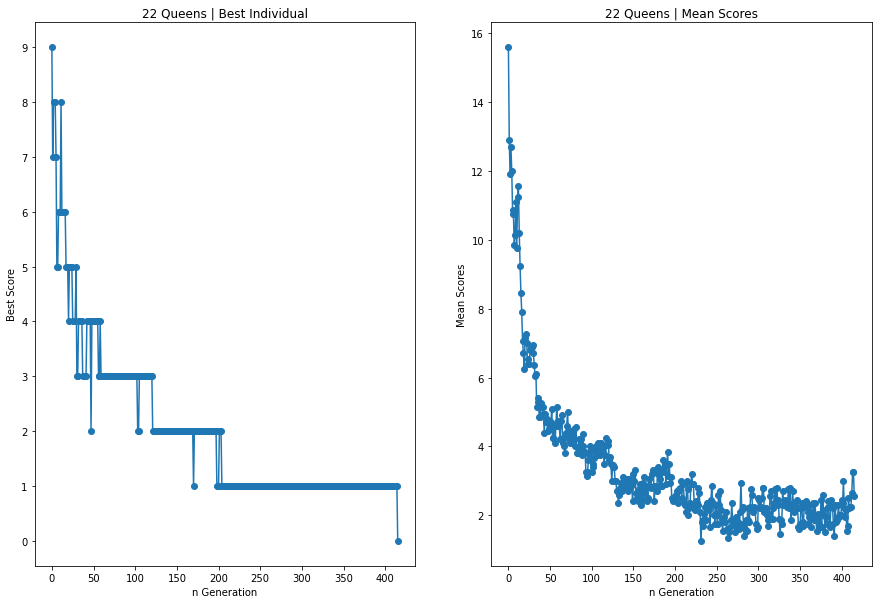

................................................................................
Number of Queens: 23
Crossing Discriminator: 0.75
Mutation Discriminator: 0.3
-------------------------------------------------------------------
  Subject | Subject code 
__________________
  1.  | [23 10  7 13  5 12 20 22 11 14  9 16  6  2  1  4  8 15 19 21 18 17  3]
  2.  | [ 6 15 14 18 23  2  3 10 22  4 19 17  7  9 21 11  8 13  1  5 12 20 16]
  3.  | [22 21  2 10  4  9 15  7 11  1 19 13 12 20 17  5  6 23 18 16 14  8  3]
  4.  | [ 4 18 21 14 20 16  8 12 17  7 10 13 22  6 15  9  2 11 23  3  1 19  5]
  5.  | [ 9 10 18 23 16  5  6 11 19 13  8  4  3  1 15 20 14  2 22 12 21  7 17]
  6.  | [14  5 20  9  2 11  6 10 15 19  8 21 17  3 18  7  4 22  1 13 16 23 12]
  7.  | [19 22 23 18  2 20 14  7 16 11  1  5 21 17 13 10  6  4  8  3 15  9 12]
  8.  | [ 1  3 18 17 21 19  4 23 11 20 12 16  2  7 15 14  6 22  9 10  8 13  5]
  9.  | [10  5 13 16 15  8 19 22 18  9 23  2  6 12 14 11 20  7  4 17  1  3 21]
  10.  | [15  1  

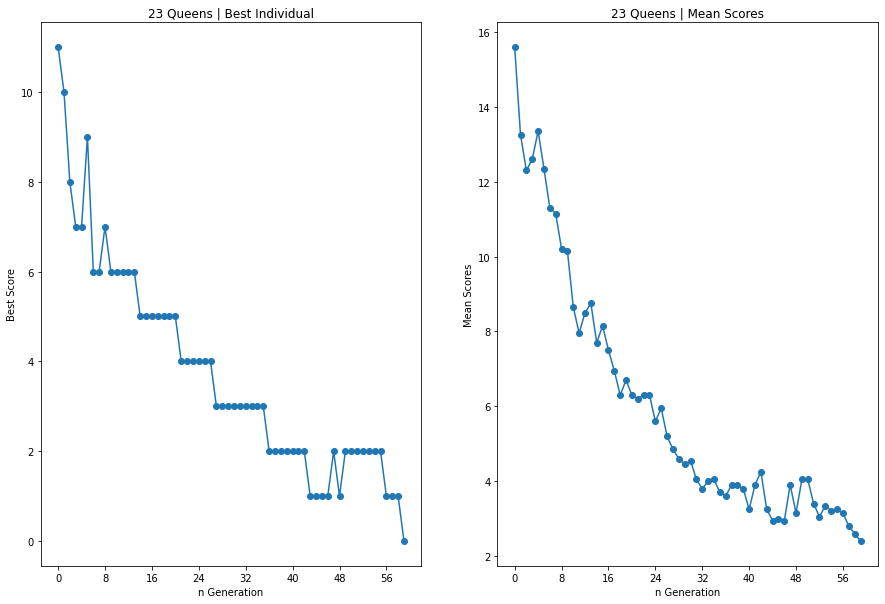

................................................................................
Number of Queens: 24
Crossing Discriminator: 0.75
Mutation Discriminator: 0.3
-------------------------------------------------------------------
  Subject | Subject code 
__________________
  1.  | [14  2  1 16  3  9 15 13 20  7 24 17  6 11  8 10 23 22  4 18 12  5 19 21]
  2.  | [ 8 11  9  4 22 16 23 20 18 10 12 19 24 14  7  1  2 15  6 17  5 21  3 13]
  3.  | [21 15 22  5 11 14 24  6 19  7  2  3  4  1 12 18 20  9 23 10  8 13 16 17]
  4.  | [22 17 15 19  8  2 23  6  5 13 21 14  7  3 20 11 12 18  4 24  9 10  1 16]
  5.  | [ 6 16 19 11  8 21 23 17  1  3  7 24 15 22 13  2 20  5 10 18  9 14 12  4]
  6.  | [13 17 19 14 22 24  3 10 23 11 16  2  8 15  6 20  9  7  5  4 21 18 12  1]
  7.  | [ 4 14  6  2 20 22  1 16 17  3 19 23 10  5 18 13 21  9 12  8 24 11  7 15]
  8.  | [ 5  6 13 17 20  4  2 10  7  9  1  8 19 22 21 15 18 16 23  3 11 14 12 24]
  9.  | [16  8 15 13  9 21 11  1 23 20  4  6  2 22  7  3 19 10 18  5 14 

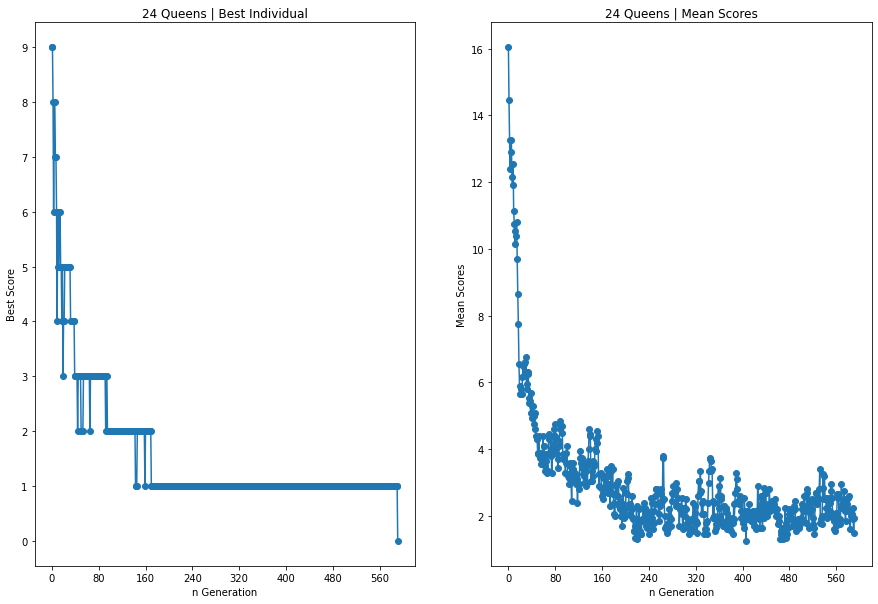

................................................................................
Number of Queens: 25
Crossing Discriminator: 0.75
Mutation Discriminator: 0.3
-------------------------------------------------------------------
  Subject | Subject code 
__________________
  1.  | [ 2  4 18 19 17 16 11 12  9 25  3  6 24 23 13 21 15 22 20 10  5  8 14  7
  1]
  2.  | [21  7 11 23  3 17  6  8 24  4 20  9 12 14 18 19 13 16 15  2  1  5 10 25
 22]
  3.  | [ 3  7 17  9  1  8 21 11 12 24 14 23 10  5 18 19 13  6 22 25  4  2 16 15
 20]
  4.  | [ 5  9 18 16  6 12 19 24 10  4 15  2  3  1 13 23  7 22 14 20 11 25 17  8
 21]
  5.  | [23  4 11 17 25  8  5  1 10  7  3 13 20  6 22 15 24 21 19 14  9 16 18  2
 12]
  6.  | [13  8  1  4 22  6 15 19 18 11  7  2 12 16 25 20 10 24 17 23 14  3 21  9
  5]
  7.  | [19 18  2  9 15 21 13 14  1  7 25 22  5 12  3 10  4 24 23 17 16  8 20  6
 11]
  8.  | [ 5 21 12  6  1  8 20  9  7 14 23 15 25 24  2 17  4 19 18 10  3 16 11 22
 13]
  9.  | [16  9  2  6  5 12 17 15 18 20 1

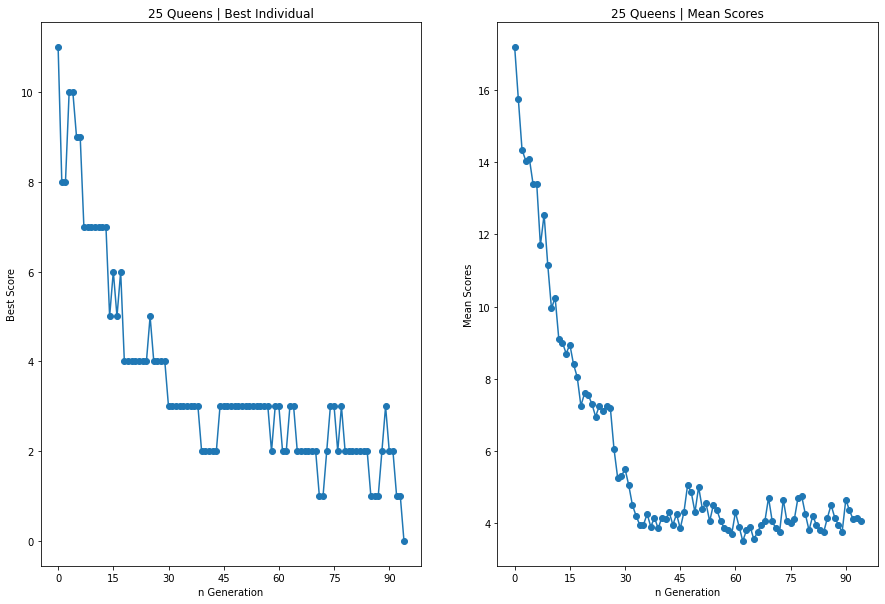

................................................................................
Number of Queens: 26
Crossing Discriminator: 0.75
Mutation Discriminator: 0.3
-------------------------------------------------------------------
  Subject | Subject code 
__________________
  1.  | [ 1 11 16 20 21 24  4 22 12  3  8 13  2  6  5 25  7 14 23 15 19 17 26 18
  9 10]
  2.  | [13 18  3 19  5 15 22  7 20 11  2 16 21 24  6  9  1 26 12 23 25 10  8  4
 17 14]
  3.  | [ 6 17 11  3 25 15 22 19 26  7 21 18 23 12  5  2 10  9 16  1 13  4  8 14
 24 20]
  4.  | [18 13 17 16  8  2 14  7  6 24 23 12  5 10 20 11 26  3 21 15 19  9  1 25
  4 22]
  5.  | [18 13 26  8  5 21 24 23 25 22  1  2  3  4 16 10  7 14 11 19 20 12  9 17
  6 15]
  6.  | [ 3  2 19 18 22 11 25  4  5  1 24 14  9 12  7 13  8 21 16 17  6 23 26 10
 20 15]
  7.  | [13 23  3  9 25  7  5 24 22 15 14 10  2  6 26  8 17 20 19 21 12  4 18  1
 11 16]
  8.  | [12 24 15 23  2 13 22 20  5  1 25 11 26 16  6 21  4 19 10  8 14  7 17  3
 18  9]
  9.  | [ 5  8  

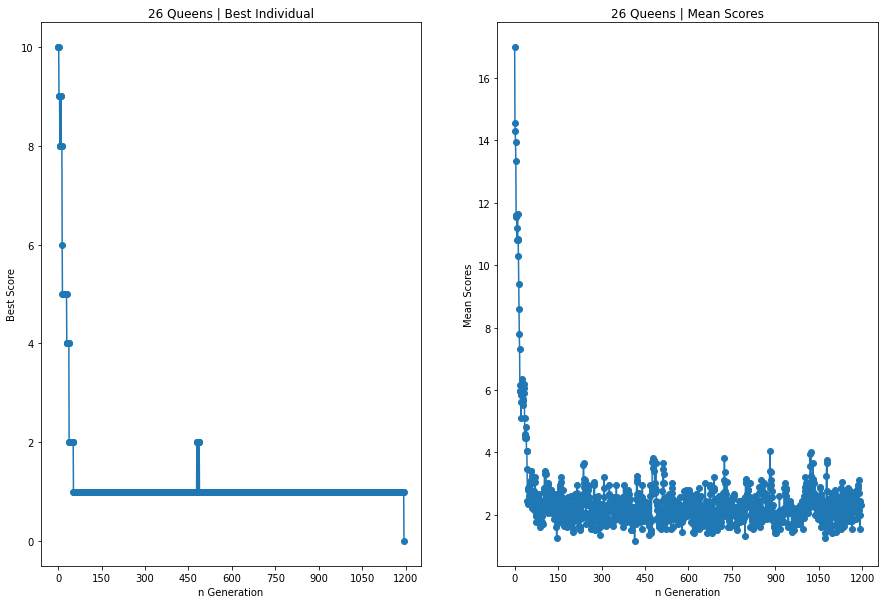

................................................................................
Number of Queens: 27
Crossing Discriminator: 0.75
Mutation Discriminator: 0.3
-------------------------------------------------------------------
  Subject | Subject code 
__________________
  1.  | [10 15  7 22  4 12  6 13  1 19 21 17 26 20 23  8  2 24 11  5  3 14 16 27
  9 25 18]
  2.  | [ 3  2 17  4 15 10  5 26 19 21  9 14 25  6  7  1 12 16 18 23 13 20 27 22
 24 11  8]
  3.  | [23  8 25  4 27 17 11 24 15 26  5 16  7 19 22 18  6 12 21 13 14  3  9  1
  2 20 10]
  4.  | [11  8  7  3 13 23 10  2  1  6 18 19 26  9 12 20 21 27  5 15 16 24 14  4
 17 25 22]
  5.  | [27 20 13 26 14  2  8  9  7 10  4 19 12 25 18 16 22  1 23  6 15  5 21 17
 24  3 11]
  6.  | [13  1 12 26 22 17 18  3 20  6  2  8 19 25  5 16  9 14 15 21  4 27  7 24
 23 11 10]
  7.  | [26  1 17 22 19 15 27  7  6 18 16 10  8 25  4 13  2 14  9 11 20 24 12  5
  3 21 23]
  8.  | [20 11 26  9  4 13 16 21 18 14 24 10 25 19 22  8  2  7  3  5  6 15 23  1
 27

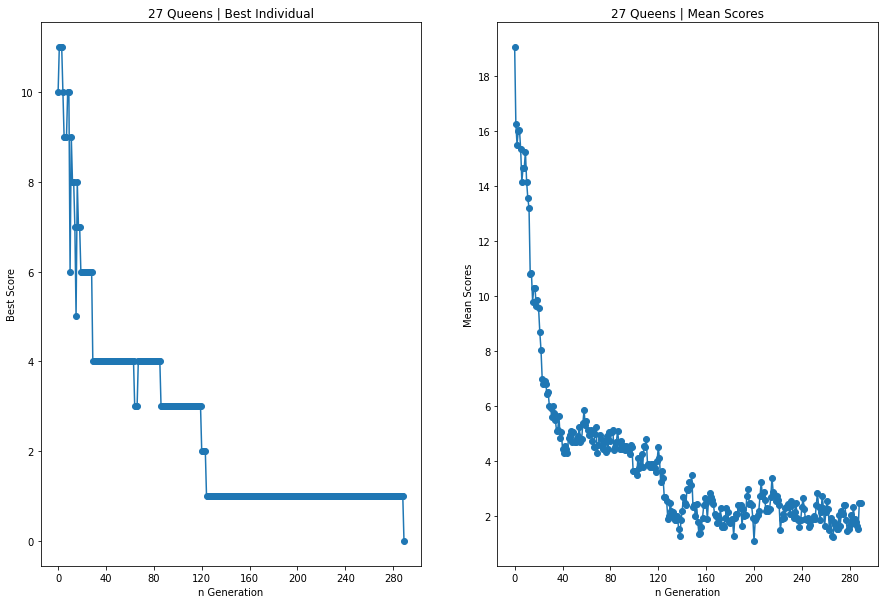

................................................................................
Number of Queens: 28
Crossing Discriminator: 0.75
Mutation Discriminator: 0.3
-------------------------------------------------------------------
  Subject | Subject code 
__________________
  1.  | [ 9 11 19 25 16  1 24 23 15 14 21 13  8  5 20 22  7 12 17 26  2 10  6 28
 18  4 27  3]
  2.  | [27  3 19  9 23 12  2  7 26 24  6 11 25  8 18 13 10 16 28 22  4 15 14 20
 21  1 17  5]
  3.  | [18 28  3  1  4 15 20 22 25 27  8 26 16 11 19  5 14 23 24 10 12  9  7 21
 13  2  6 17]
  4.  | [ 3  4 21 14  5 11 22 28 15  8 23 18 26 25  7  2 13 12 27  1 24 10  9 19
 17  6 16 20]
  5.  | [ 4  5  8  2 22 13  7  9  3 12 11 25 14  1 20 16 28 18 19 26 17 10 24 27
 15  6 23 21]
  6.  | [14 25  5 12 17  7 24 13 11 26 28 18  9 20  2 21  1  6 27 23 22  8 16  4
 15 19 10  3]
  7.  | [19 21 15 27 28 11 10  1 26 22 24 16 13 25  4 14  7 18  5  9 20 23 12  6
 17  2  8  3]
  8.  | [28 13 19 24 11  7  9 16 25 26 14  5 27  4 17 12 15 10 

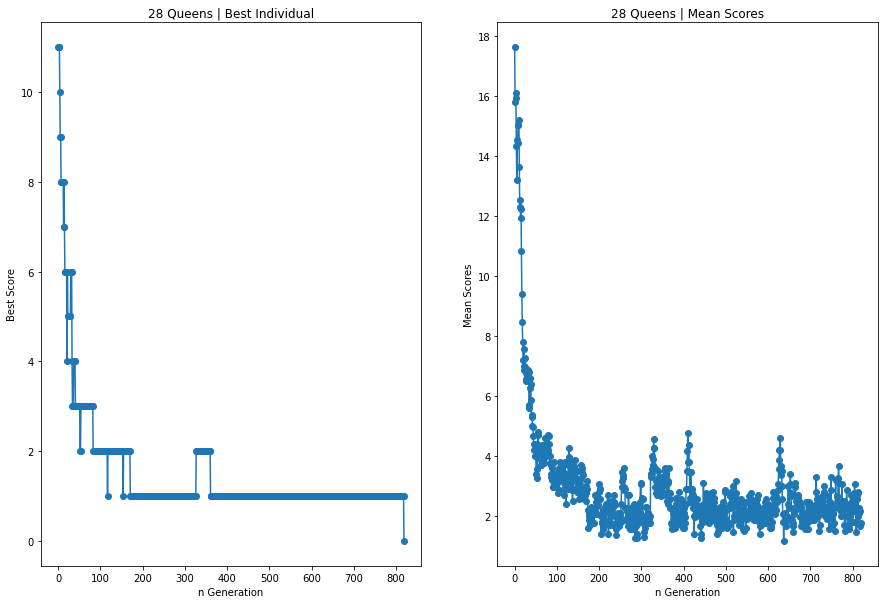

................................................................................
Number of Queens: 29
Crossing Discriminator: 0.75
Mutation Discriminator: 0.3
-------------------------------------------------------------------
  Subject | Subject code 
__________________
  1.  | [ 5 15 14  7 16  8 24  9 20  3 25  2 11 13 26  6 21  4 19  1 22 10 18 12
 23 17 27 29 28]
  2.  | [ 5  4 14 17 12 20 29 18 23  6 19 26 27 10  7 13 25 21 15  8 11  2 24  1
 22  3 16 28  9]
  3.  | [24 20 29 12 18  6  4 13 10 23  9 27  3 28 26 16 17  2 11  7 19 21  1 15
  5  8 22 25 14]
  4.  | [22 15 16  9 14 27 19  5 20 29 18  2 11  3 25  4  7 13 17  1 23 26 21  8
 10 24  6 28 12]
  5.  | [26 24 11 20  1 14 19 10  6  9  5  7 22 23 29 28 15 16 17  8 21 18 13 27
 12  2  4  3 25]
  6.  | [10 11 20 29 14  8 28 21 19  4 22  3 12 17 26  6  9  1  5 16 15 27  2 23
  7 24 18 13 25]
  7.  | [ 4 17 29 26  6 14 11 19  7  9 27  8  3 23 24 22 15 16 21  1 13  2 20 12
 10 25 18 28  5]
  8.  | [10 19  4 28  8 11 15 13 24 22 26 

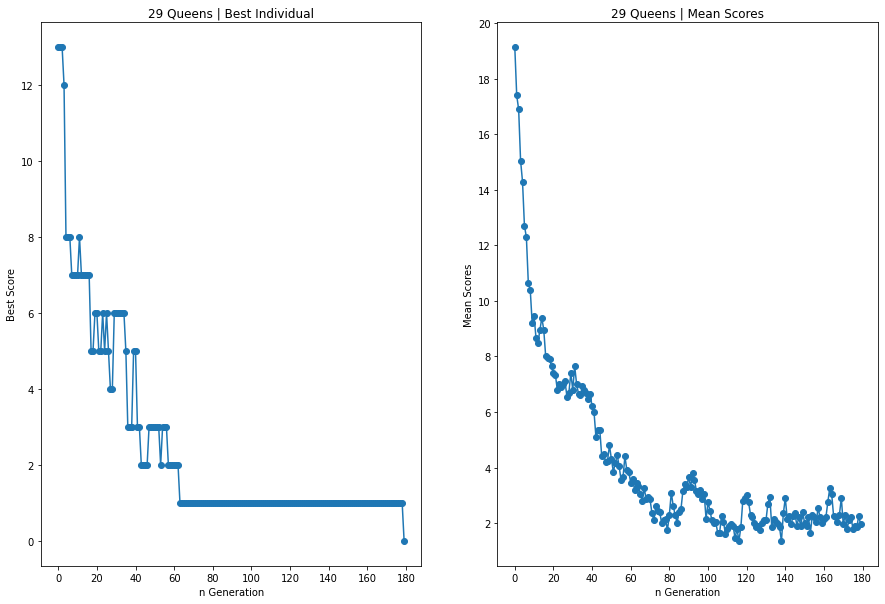

................................................................................
Number of Queens: 30
Crossing Discriminator: 0.75
Mutation Discriminator: 0.3
-------------------------------------------------------------------
  Subject | Subject code 
__________________
  1.  | [10 28 25 14 17  5  1 30 24  6  8 22  9 29 20 23  4 12 11 18  2  7 26 19
  3 27 16 13 21 15]
  2.  | [29 11 27  3 15 14 18  2 30 17 12 20  7 26 22 28 21 24 16 13  1 23  5  8
 10 25 19  9  4  6]
  3.  | [15  8 19 12 27  2 26  1  5 24 20 10 17 11 23 16  4 22 29 28 21  9  6 13
 25  7 18 14 30  3]
  4.  | [12  2 27 25 23 30 14  3  1 15 26  5 20  9 21 10  6 28 17 22 16  8 11 18
  4 19  7 24 13 29]
  5.  | [24 25  3 30 14 18 26 10  1 15  8 13 27 20 17 11 19 21  5 28 22  9 12  4
 29 16  7  6  2 23]
  6.  | [15  3 12  2  6  1  8 24 14 21 20 17 28 23 22 16  7 10 30 19 25  4 26  9
 29 13  5 27 18 11]
  7.  | [19 30  5 20 12  4  8 26 11  7 24  9 14 16 10  6 28  1 25 18 13  2 21 27
  3 15 17 22 23 29]
  8.  | [ 3 10 13 27 

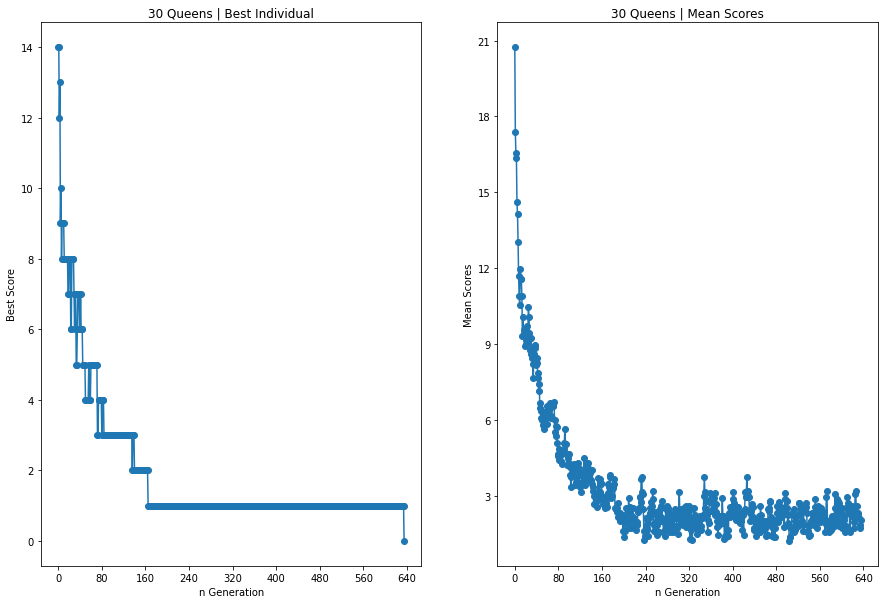

................................................................................
Number of Queens: 31
Crossing Discriminator: 0.75
Mutation Discriminator: 0.3
-------------------------------------------------------------------
  Subject | Subject code 
__________________
  1.  | [26 18 11 19  9 21 22 23 20  4 17 10  6 25  2 14 31 16  8  3 29 28  5 27
 30 24 13 15  7 12  1]
  2.  | [14 12 24 21 15 31 13  1  6 22  8 28  9 19 29  7 11 16  2 27 18 17 20 25
 26  3  4 23  5 30 10]
  3.  | [24 19 11 31  9  7  5 17 10 28 13  2 14 23  3 20 15  8 25 26  1 30  4 22
 12 18 27 16  6 21 29]
  4.  | [ 4  5 15 25 12 27  1 20 14 26  6  3 30 23  2 24 10  8 16 31 18 13 29 19
  9 21 17 22 28 11  7]
  5.  | [ 7 30 28 26  8  3  4 11  5  9 21 24 31 18 10 22 13  6  2 27 14 19 20 23
 17  1 15 25 16 29 12]
  6.  | [29  8  7 26 30 14 25 19 22  6  2 27  3  9 15  5 13 10 20 21 18 31  4 12
  1 16 11 28 23 24 17]
  7.  | [11 13 25 10  3  5 16  1  8 14 19 26  4  7 17 12 20 18 23 27 21  6 30 22
  9 15 24  2 31 29 28]


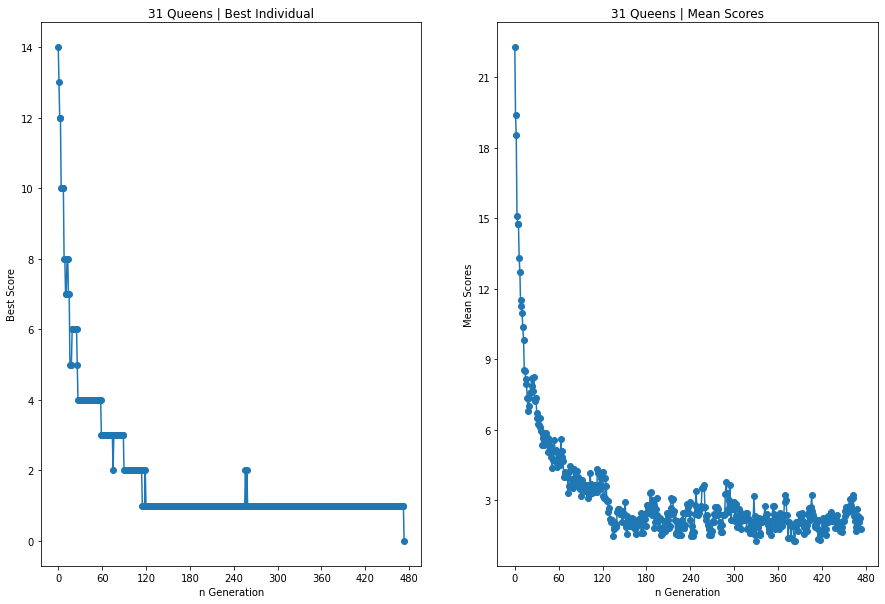

................................................................................
Number of Queens: 32
Crossing Discriminator: 0.75
Mutation Discriminator: 0.3
-------------------------------------------------------------------
  Subject | Subject code 
__________________
  1.  | [27  5 15  1 17 14 19 12 11  2 28 31 32 23 16 13  3  8 24  6 25 22  9 20
 18 10 26 21  7 30 29  4]
  2.  | [29  9 22  3 15 28  4 26  1 23 31  6 20 14  2  5 19 25 10 24  8 32 27 21
 18 12 17 30 13  7 16 11]
  3.  | [29  4 30 15 28 13  3 26 21 31 11 23  5 19 22 20 12 25  8 16  1  9 17  7
 10 32  6 14 27 24  2 18]
  4.  | [23 17 30 14 24  3  7 11 28 16 12 25 10 13  2  1 26  8 19 22 15 29  4 20
 32 18  6  5 27 31  9 21]
  5.  | [ 9 20 16 24 32 15 21 18 11 14 12 28  4 26 29 23 30  2  1 17 19 13 22  3
  6 25  5  8 27  7 10 31]
  6.  | [31  1  3 15 21 23 20  5 22 10 18 27  9 24 14 11  2 16 28  8 12 25  7 30
 19 32  6  4 29 13 17 26]
  7.  | [11 15  9 17 18 21 28 14  4 25 29  6 23 22 27  7 10 26 30 31 20 13 19 24
 12  

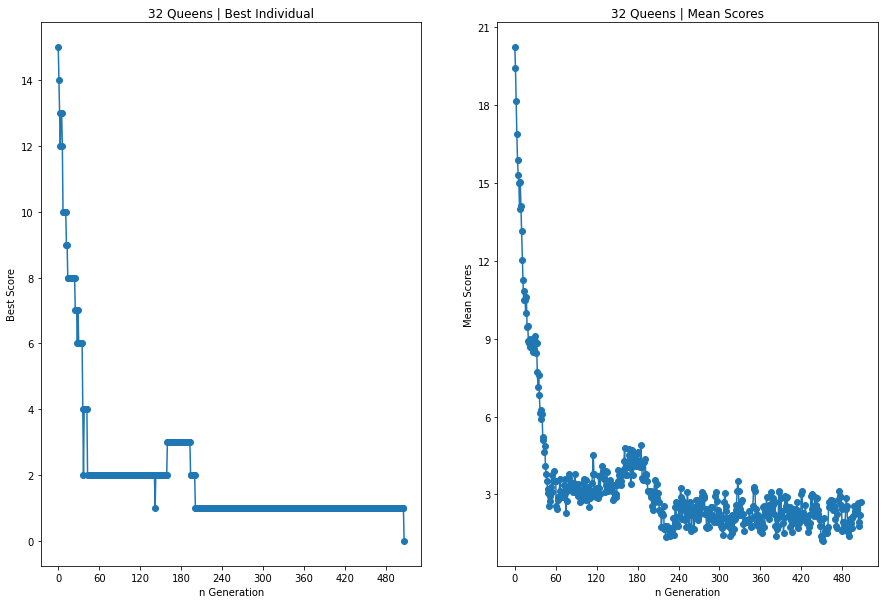

................................................................................
Number of Queens: 33
Crossing Discriminator: 0.75
Mutation Discriminator: 0.3
-------------------------------------------------------------------
  Subject | Subject code 
__________________
  1.  | [ 7  5 32  9 19  3 15 33  8 10 18 16 22 12 23 25 30  2 26 28 21 14 20 31
  6 27  4  1 17 11 24 13 29]
  2.  | [25  3  4  5 21 10 16 20  7  9 22 24 14 27  6 23 19 32  2 31 33  8 26 12
 11  1 28 13 15 17 30 29 18]
  3.  | [ 6  8 32 20 26 12 29 31 30 19  5  4  2 28  3 25  1  7 24 23 15 17  9 10
 16 11 27 22 18 33 14 21 13]
  4.  | [10 32 29 21 18  4 31 22 25 28  6  7 14 26 33 23  3  2 24  9 19 13  5 16
 12 20 11 27 15  1 17 30  8]
  5.  | [ 4  7  9  2 16 18  6 24 12 21 30 13 31  1 23 17 11  3 22  8 25  5 15 19
 10 29 32 33 20 26 27 28 14]
  6.  | [15 23 27 26 28 24 11  1 22 20 12 19  5 17 16  6  8  9  2 21 18 29 30 31
 13 10 25 32 14  7 33  4  3]
  7.  | [32  8  7  9 15 14  6 10 30 12  2 28 29 23 25  1 18 24 11  4

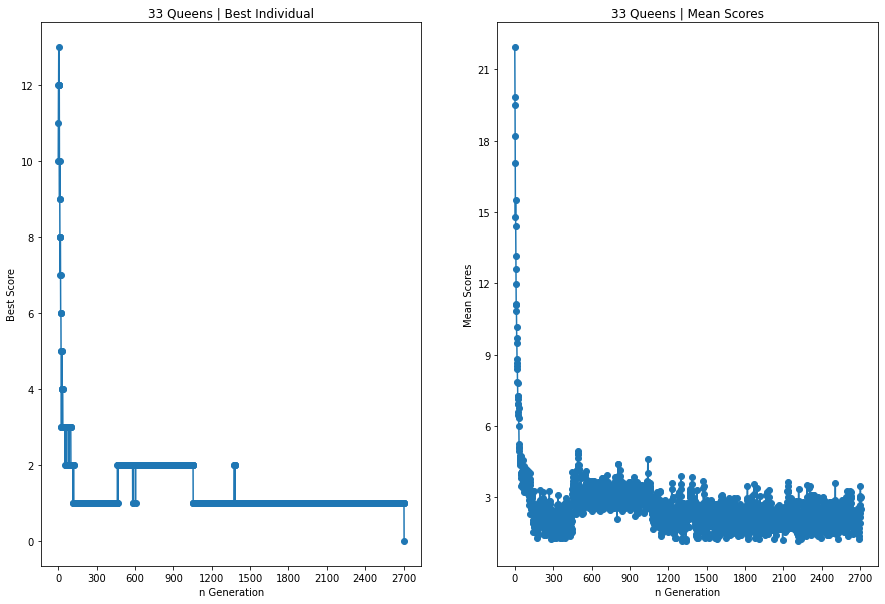

................................................................................
Number of Queens: 34
Crossing Discriminator: 0.75
Mutation Discriminator: 0.3
-------------------------------------------------------------------
  Subject | Subject code 
__________________
  1.  | [12 32 18  9 26 33  3 30  7 34 22 25  1 19 16  8  4 24 15 21 17 14 28 11
 23  2 20 27 31 10  5  6 13 29]
  2.  | [28 23 15 24  3 12 14  7 32  6 21 27 13 20 34 31 29  5 19 11 26 25 18 22
 16  4  1 30  2 17  8  9 10 33]
  3.  | [34 23 30 14 21 24  5 13 10  3 22 11 33 16  6  4 20 25 19  9 18 31  1  2
 29 12 26  7 32 27 17 15  8 28]
  4.  | [33 23 12 11  7  3 21  5 34  4 15 20 16  6  9 18  8 28 27 13 22 14 24 32
 17 30  2 31 19 25 10 29  1 26]
  5.  | [ 6 13 23 27  9 30 18 14 26 29 10  1  4 20 22  3 34  7 28 33  2 16 24 17
 11  8 31 19 32 12 15 21 25  5]
  6.  | [30 11 26 21 15  6 19  4 25 23 13  2  9 10 27  8 32 18  1 17  5  7  3 16
 14 31 33 22 12 28 24 29 20 34]
  7.  | [ 7  6 29  4 28 26  3 18 25 12 17 34 11 23

KeyboardInterrupt: 

In [9]:
#MAIN 
crossDiscriminator    = 0.75
mutationDiscriminator = 0.3
populationSize        = 20
boardStart            = 4
boardStop             = 100
MAXGENERATION         = 10000
boardSize             = np.arange(boardStart,boardStop+1)

for size in boardSize:
    print("................................................................................")
    print("Number of Queens: {}".format(size))
    print("Crossing Discriminator: {}".format(crossDiscriminator))
    print("Mutation Discriminator: {}".format(mutationDiscriminator))
    start             = time()
    evolution         = EvolutionAlgorithm(chessboardSize =size, populationSize=populationSize ,
                                            crossDiscriminator=crossDiscriminator,mutationDiscriminator=mutationDiscriminator,
                                           maxGeneration=MAXGENERATION)
    result, BestScore,bestData, avgScore = evolution.doTheEvolution()
    stop              = time()
    totalTime         = stop - start
    printStats(result, BestScore,totalTime )
    drawPlots(size, bestData, avgScore)